## Importing libraries and seeding for reproducibility

In [1]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    """
    Ensures reproducibility across Python, NumPy, and PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # deterministic results - slightly slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

g = torch.Generator().manual_seed(42) # for data loaders

In [2]:
#importing all the necessary libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE


### Running on GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data Loading and Preprocessing

### Load data

In [5]:
train = pd.read_csv('supervised_train_new.csv')
val = pd.read_csv("supervised_val_new.csv")
test = pd.read_csv("supervised_test_new.csv")

In [6]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", val.shape)

Shape of the sampled train data: (323200, 57)
Shape of the sampled test data: (434400, 57)
Shape of the sampled CV data: (161600, 57)


In [7]:
train_df_c, val_df_c, test_df_c = train.copy(), val.copy(), test.copy()

### Scale data

In [8]:
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
target = 'faultNumber'

In [9]:
scaler = StandardScaler()
train_df_c[features] = scaler.fit_transform(train_df_c[features])
val_df_c[features] = scaler.transform(val_df_c[features])
test_df_c[features] = scaler.transform(test_df_c[features])

### Create sequences

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, df, features, target, seq_len=30, label_map=None, run_col="seq_id"):
        self.X = []
        self.y = []
        self.seq_len  = seq_len
        self.features = features
        self.target   = target
        self.label_map = label_map
        self.run_col   = run_col

        df = df.sort_values([run_col, "sample"]).reset_index(drop=True)

        for run_id, g in df.groupby(run_col):
            g = g.reset_index(drop=True)
            if len(g) < seq_len:
                continue

            for i in range(len(g) - seq_len + 1):
                seq   = g.iloc[i:i+seq_len][features].values
                label = g.iloc[i+seq_len - 1][target]

                if self.label_map is not None:
                    label = self.label_map[label]

                self.X.append(seq)
                self.y.append(label)

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )


### Extracting labels for testing

In [11]:
def extract_all_labels(df, features, target, seq_len=30):
    return [int(df.iloc[i+seq_len - 1][target]) for i in range(len(df) - seq_len)]

y_train_raw = extract_all_labels(train_df_c, features, target)
y_val_raw = extract_all_labels(val_df_c, features, target)
y_test_raw = extract_all_labels(test_df_c, features, target)

In [12]:
faults_to_exclude = [3, 9, 15]

unique_labels = sorted(set(y_train_raw) | set(y_val_raw) | set(y_test_raw))
unique_labels = [label for label in unique_labels if label not in faults_to_exclude]

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
num_classes = len(label_to_index)


In [13]:
train_dataset = SequenceDataset(train_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")
val_dataset = SequenceDataset(val_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")
test_dataset = SequenceDataset(test_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")

### Data loading in batches

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,generator = g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,generator = g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,generator = g)

## Model Architecture and Training

## Creating model

In [15]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes,
                 num_heads=4, ff_dim=128, dropout=0.4,
                 max_len=300):
        """
        max_len: maximum sequence length you expect (>= your seq_len, e.g. 30).
        """
        super().__init__()

        # Convolutional layers 
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=dropout)

        # Positional embeddings 
        # d_model = 64 after the CNN
        self.d_model = 64
        self.max_len = max_len
        # shape: (1, max_len, d_model)
        self.pos_emb = nn.Parameter(
            torch.randn(1, max_len, self.d_model)
        )

        # Transformer block 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=2
        )

        # Pooling and classifier 
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1  = nn.Linear(self.d_model, 64)
        self.fc2  = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, L, input_dim)

        # CNN feature extraction 
        x = x.transpose(1, 2)                     # (B, input_dim, L)
        x = F.relu(self.bn1(self.conv1(x)))       # (B, 32, L)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))       # (B, 64, L)
        x = self.dropout(x)

        x = x.transpose(1, 2)                     # (B, L, 64)

        B, L, C = x.shape
        # Safety check: L must not exceed max_len
        if L > self.max_len:
            raise ValueError(f"Sequence length {L} > max_len {self.max_len}")

        # Add positional embeddings 
        # pos_emb: (1, max_len, C) -> slice to (1, L, C) and broadcast to (B, L, C)
        pos = self.pos_emb[:, :L, :]              # (1, L, 64)
        x = x + pos                               # (B, L, 64)

        # Transformer encoder 
        x = self.transformer(x)                   # (B, L, 64)

        # Pooling over time 
        x = x.transpose(1, 2)                     # (B, 64, L)
        x = self.pool(x).squeeze(-1)              # (B, 64)

        # Classifier head 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)                        # (B, num_classes)


In [16]:
model = TransformerClassifier(
    input_dim=len(features),
    num_classes=num_classes 
).to(device)

### Model Training

In [17]:
def train_classifier(
    model, train_loader, val_loader, criterion, optimizer,
    epochs=30, patience=7, grad_clip=1.0, scheduler_type="cosine",
    run_tag: str = "run",             # name per ablation run
    ckpt_dir: str = "checkpoints",   
    plot: bool = True,                
    return_history: bool = False,     
    load_best: bool = False,          
    device=device
):
    import os
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, f"best_model_{run_tag}.pth")

    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Scheduler
    if scheduler_type == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3, verbose=True
        )
    elif scheduler_type == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs
        )
    else:
        scheduler = None

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # Training 
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Scheduler step
        if scheduler_type == "plateau":
            scheduler.step(avg_val_loss)
        elif scheduler_type == "cosine":
            scheduler.step()

        # Logging
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
              f"LR: {current_lr:.6f}")

        # Early stopping to prevent overfitting
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), ckpt_path)   
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plots 
    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('CrossEntropy Loss')
        plt.title('Loss Over Epochs')
        plt.legend(); plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend(); plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        plt.close('all')

    if load_best and os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))

    if return_history:
        return {
            "ckpt_path": ckpt_path,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "best_val_loss": best_val_loss
        }
    else:
        return {"ckpt_path": ckpt_path, "best_val_loss": best_val_loss}


## Ablation - Dropout


Training with Dropout: 0.0

TransformerClassifier(
  (conv1): Conv1d(52, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)


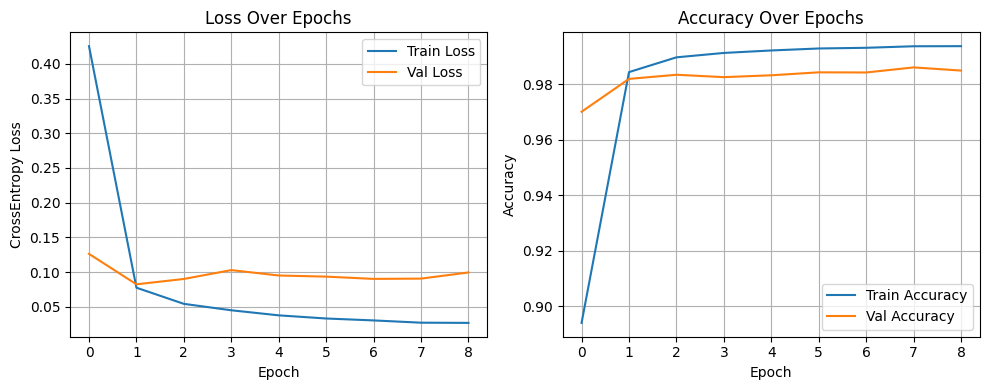

              precision    recall  f1-score   support

     Fault 0    0.98940   1.00000   0.99467    223440
     Fault 1    0.99364   0.99965   0.99664     11565
     Fault 2    0.99974   0.99792   0.99883     11565
     Fault 4    0.99544   1.00000   0.99771     11565
     Fault 5    0.93674   1.00000   0.96734     11565
     Fault 6    1.00000   0.98738   0.99365     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.97991   0.94042   0.95976     11565
    Fault 10    0.98073   0.97268   0.97669     11565
    Fault 11    1.00000   0.98063   0.99022     11565
    Fault 12    0.98479   0.90713   0.94437     11565
    Fault 13    0.97821   0.95089   0.96435     11565
    Fault 14    0.94966   1.00000   0.97418     11565
    Fault 16    0.96913   0.96100   0.96505     11565
    Fault 17    1.00000   0.97830   0.98903     11565
    Fault 18    0.99091   0.93333   0.96126     11565
    Fault 19    0.99878   0.98712   0.99291     11565
    Fault 20    0.99900   0

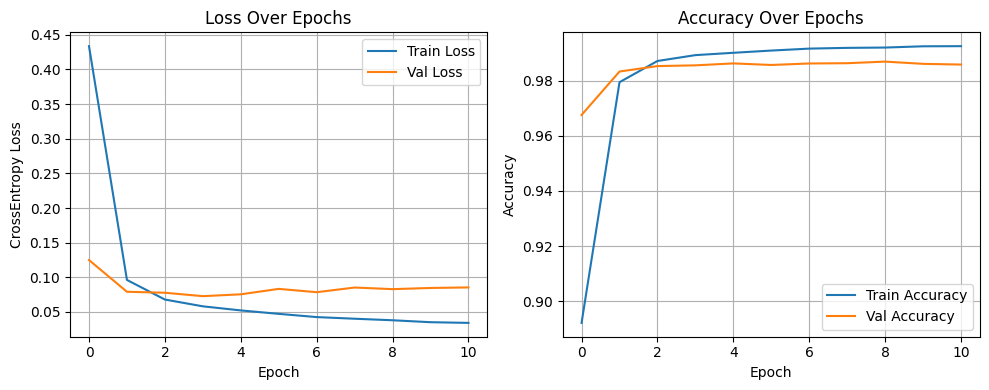

              precision    recall  f1-score   support

     Fault 0    0.99019   1.00000   0.99507    223440
     Fault 1    0.98242   1.00000   0.99113     11565
     Fault 2    0.99922   1.00000   0.99961     11565
     Fault 4    0.99604   1.00000   0.99802     11565
     Fault 5    0.99957   0.99983   0.99970     11565
     Fault 6    1.00000   1.00000   1.00000     11565
     Fault 7    0.99905   1.00000   0.99952     11565
     Fault 8    0.98252   0.96204   0.97217     11565
    Fault 10    0.99056   0.98037   0.98544     11565
    Fault 11    0.99991   0.98807   0.99395     11565
    Fault 12    0.94686   0.96299   0.95486     11565
    Fault 13    0.99594   0.95409   0.97456     11565
    Fault 14    0.99922   1.00000   0.99961     11565
    Fault 16    0.99358   0.96334   0.97822     11565
    Fault 17    0.99921   0.97977   0.98939     11565
    Fault 18    0.99237   0.93290   0.96172     11565
    Fault 19    0.99678   0.99040   0.99358     11565
    Fault 20    0.99955   0

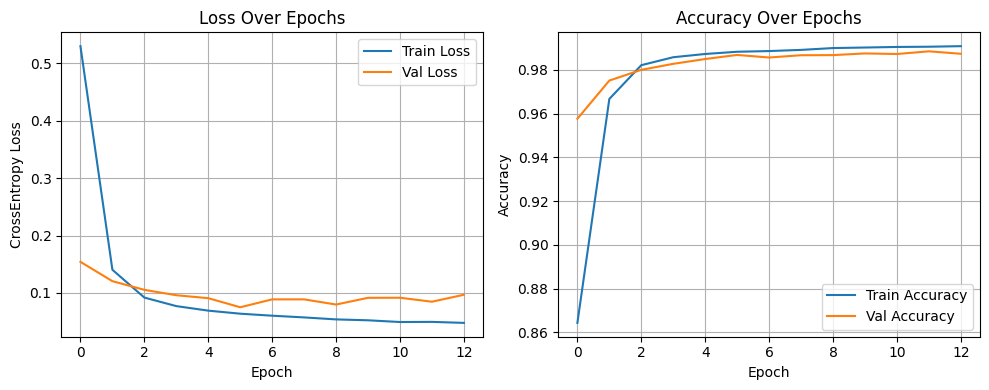

              precision    recall  f1-score   support

     Fault 0    0.98915   1.00000   0.99455    223440
     Fault 1    0.99680   0.99559   0.99619     11565
     Fault 2    0.99664   1.00000   0.99832     11565
     Fault 4    0.99690   1.00000   0.99845     11565
     Fault 5    0.99049   1.00000   0.99522     11565
     Fault 6    0.99843   0.98781   0.99309     11565
     Fault 7    0.99836   1.00000   0.99918     11565
     Fault 8    0.98205   0.97916   0.98060     11565
    Fault 10    0.99612   0.97674   0.98633     11565
    Fault 11    1.00000   0.99040   0.99518     11565
    Fault 12    0.99877   0.91111   0.95293     11565
    Fault 13    0.95748   0.96775   0.96259     11565
    Fault 14    0.97283   1.00000   0.98623     11565
    Fault 16    0.99703   0.95815   0.97720     11565
    Fault 17    0.99912   0.98115   0.99005     11565
    Fault 18    0.95805   0.94596   0.95197     11565
    Fault 19    0.99956   0.98521   0.99234     11565
    Fault 20    0.99936   0

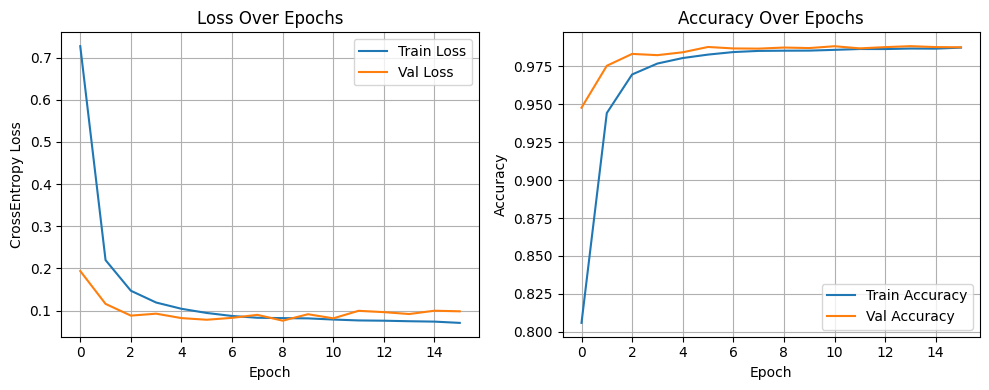

              precision    recall  f1-score   support

     Fault 0    0.99123   1.00000   0.99560    223440
     Fault 1    0.98282   0.99939   0.99104     11565
     Fault 2    0.99819   1.00000   0.99909     11565
     Fault 4    0.99836   1.00000   0.99918     11565
     Fault 5    0.98233   1.00000   0.99109     11565
     Fault 6    1.00000   1.00000   1.00000     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.95134   0.96706   0.95914     11565
    Fault 10    0.99472   0.97769   0.98613     11565
    Fault 11    0.96520   0.98798   0.97646     11565
    Fault 12    0.99942   0.89771   0.94584     11565
    Fault 13    0.98940   0.97622   0.98276     11565
    Fault 14    0.99965   1.00000   0.99983     11565
    Fault 16    0.99510   0.98366   0.98935     11565
    Fault 17    0.99719   0.98141   0.98924     11565
    Fault 18    0.98322   0.94734   0.96495     11565
    Fault 19    1.00000   0.98323   0.99154     11565
    Fault 20    1.00000   0

In [18]:
dropout_values = [0.0, 0.1, 0.2, 0.4]
criterion = nn.CrossEntropyLoss(label_smoothing=0)

for d in dropout_values:
    print(f"\nTraining with Dropout: {d}\n")
    model = TransformerClassifier(
        input_dim=len(features),
        num_classes=num_classes,
        dropout=d
    ).to(device)
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

    run_tag = f"dropout_{d}"
    info = train_classifier(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=50, patience=7,
        grad_clip=1.0, scheduler_type="cosine",
        run_tag=run_tag, ckpt_dir="checkpoints",
        plot=True,          
        load_best=True       # make sure we evaluate the best model
    )
    all_probs = []
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(y_batch.numpy())

    # Concatenate all
    all_probs = np.vstack(all_probs)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    label_names = [f"Fault {index_to_label[i]}" for i in range(num_classes)]


    # cm = confusion_matrix(all_targets, all_preds, normalize='true')
    # # print("Confusion Matrix:\n", cm)
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.title("Confusion Matrix")
    # plt.tight_layout()
    # plt.show()

    # Classification report
    print(classification_report(all_targets, all_preds, target_names=label_names, digits=5))

## Ablation - num_heads


Training with Heads: 1

TransformerClassifier(
  (conv1): Conv1d(52, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    

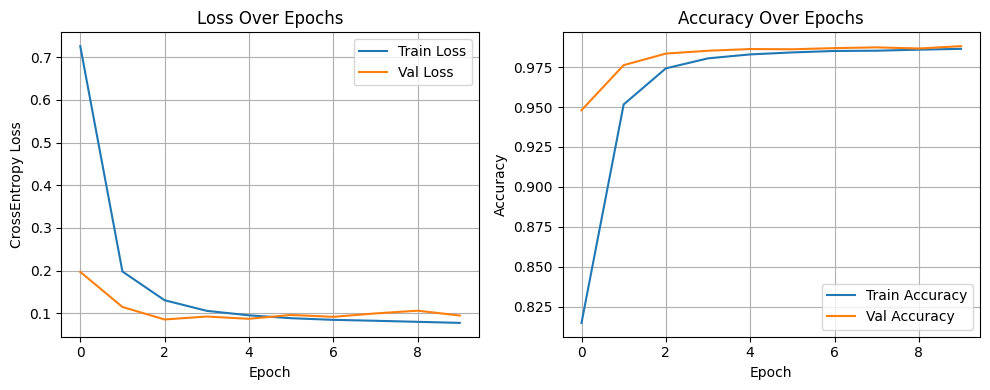

              precision    recall  f1-score   support

     Fault 0    0.98719   1.00000   0.99355    223440
     Fault 1    0.97248   0.99594   0.98407     11565
     Fault 2    0.99262   1.00000   0.99630     11565
     Fault 4    0.99552   1.00000   0.99776     11565
     Fault 5    0.98125   1.00000   0.99054     11565
     Fault 6    0.99885   0.98029   0.98948     11565
     Fault 7    0.99948   1.00000   0.99974     11565
     Fault 8    0.98015   0.96481   0.97242     11565
    Fault 10    0.99911   0.96801   0.98331     11565
    Fault 11    1.00000   0.98184   0.99084     11565
    Fault 12    0.99609   0.92486   0.95915     11565
    Fault 13    0.99846   0.95331   0.97536     11565
    Fault 14    0.99776   1.00000   0.99888     11565
    Fault 16    0.98555   0.94336   0.96399     11565
    Fault 17    1.00000   0.97674   0.98823     11565
    Fault 18    0.94365   0.94267   0.94316     11565
    Fault 19    0.97703   0.98928   0.98311     11565
    Fault 20    0.99781   0

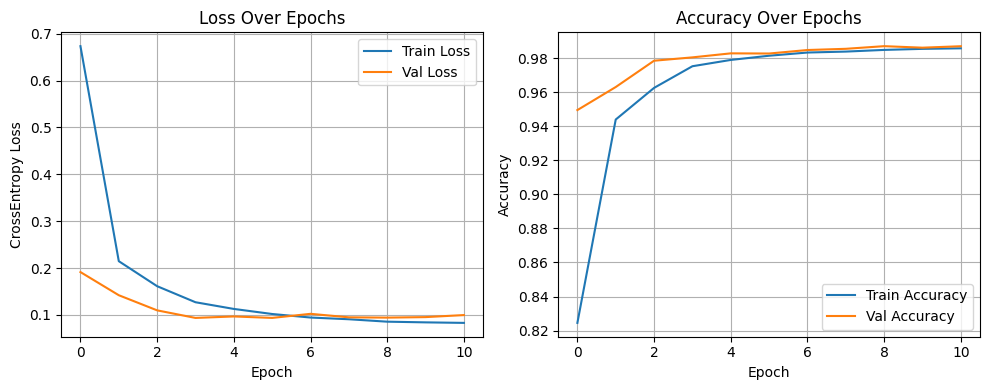

              precision    recall  f1-score   support

     Fault 0    0.98579   1.00000   0.99285    223440
     Fault 1    0.98699   0.99706   0.99200     11565
     Fault 2    0.99296   1.00000   0.99647     11565
     Fault 4    0.99715   1.00000   0.99858     11565
     Fault 5    0.93447   1.00000   0.96613     11565
     Fault 6    1.00000   0.92797   0.96264     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.95636   0.95512   0.95574     11565
    Fault 10    0.99089   0.96879   0.97971     11565
    Fault 11    0.99921   0.98764   0.99339     11565
    Fault 12    0.94432   0.93411   0.93919     11565
    Fault 13    0.97924   0.95858   0.96880     11565
    Fault 14    1.00000   1.00000   1.00000     11565
    Fault 16    0.99240   0.92616   0.95814     11565
    Fault 17    0.99991   0.97657   0.98810     11565
    Fault 18    0.98262   0.91924   0.94987     11565
    Fault 19    0.99815   0.97882   0.98839     11565
    Fault 20    0.99973   0

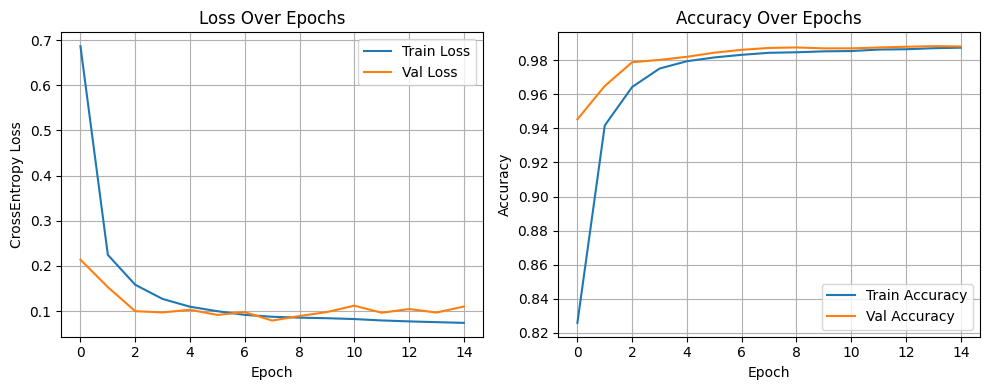

              precision    recall  f1-score   support

     Fault 0    0.99128   1.00000   0.99562    223440
     Fault 1    0.97177   1.00000   0.98568     11565
     Fault 2    0.94538   0.99965   0.97176     11565
     Fault 4    0.99630   1.00000   0.99814     11565
     Fault 5    0.97760   0.99991   0.98863     11565
     Fault 6    1.00000   0.98132   0.99057     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.99802   0.95841   0.97781     11565
    Fault 10    0.99724   0.96965   0.98325     11565
    Fault 11    0.99982   0.98556   0.99264     11565
    Fault 12    0.98086   0.90834   0.94321     11565
    Fault 13    0.98035   0.96195   0.97106     11565
    Fault 14    0.99974   1.00000   0.99987     11565
    Fault 16    0.98573   0.97933   0.98252     11565
    Fault 17    0.99877   0.98029   0.98944     11565
    Fault 18    1.00000   0.94656   0.97255     11565
    Fault 19    0.97012   0.98245   0.97624     11565
    Fault 20    0.99193   0

In [19]:
numheads_values = [1,2,8]
criterion = nn.CrossEntropyLoss(label_smoothing=0)

for n in numheads_values:
    print(f"\nTraining with Heads: {n}\n")
    model = TransformerClassifier(
        input_dim=len(features),
        num_classes=num_classes,
        num_heads=n
    ).to(device)
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

    run_tag = f"heads_{n}"
    info = train_classifier(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=50, patience=7,
        grad_clip=1.0, scheduler_type="cosine",
        run_tag=run_tag, ckpt_dir="checkpoints",
        plot=True,          
        load_best=True       # make sure we evaluate the best model
    )
    all_probs = []
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(y_batch.numpy())

    # Concatenate all
    all_probs = np.vstack(all_probs)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    label_names = [f"Fault {index_to_label[i]}" for i in range(num_classes)]

    # cm = confusion_matrix(all_targets, all_preds, normalize='true')
    # # print("Confusion Matrix:\n", cm)
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.title("Confusion Matrix")
    # plt.tight_layout()
    # plt.show()

    # Classification report
    print(classification_report(all_targets, all_preds, target_names=label_names, digits=5))

## Ablation - learning rate and weight decay


Training with LR: 0.0005 and WD: 0.0

Epoch 1/50 | Train Loss: 0.3066 | Train Acc: 0.9213 | Val Loss: 0.0930 | Val Acc: 0.9840 | LR: 0.000500
Epoch 2/50 | Train Loss: 0.0942 | Train Acc: 0.9818 | Val Loss: 0.1255 | Val Acc: 0.9830 | LR: 0.000498
Epoch 3/50 | Train Loss: 0.0754 | Train Acc: 0.9859 | Val Loss: 0.1083 | Val Acc: 0.9871 | LR: 0.000496
Epoch 4/50 | Train Loss: 0.0655 | Train Acc: 0.9880 | Val Loss: 0.1128 | Val Acc: 0.9848 | LR: 0.000492
Epoch 5/50 | Train Loss: 0.0592 | Train Acc: 0.9893 | Val Loss: 0.1324 | Val Acc: 0.9859 | LR: 0.000488
Epoch 6/50 | Train Loss: 0.0538 | Train Acc: 0.9901 | Val Loss: 0.0831 | Val Acc: 0.9884 | LR: 0.000482
Epoch 7/50 | Train Loss: 0.0521 | Train Acc: 0.9904 | Val Loss: 0.0732 | Val Acc: 0.9885 | LR: 0.000476
Epoch 8/50 | Train Loss: 0.0485 | Train Acc: 0.9910 | Val Loss: 0.0894 | Val Acc: 0.9892 | LR: 0.000469
Epoch 9/50 | Train Loss: 0.0456 | Train Acc: 0.9913 | Val Loss: 0.1197 | Val Acc: 0.9872 | LR: 0.000461
Epoch 10/50 | Train Loss:

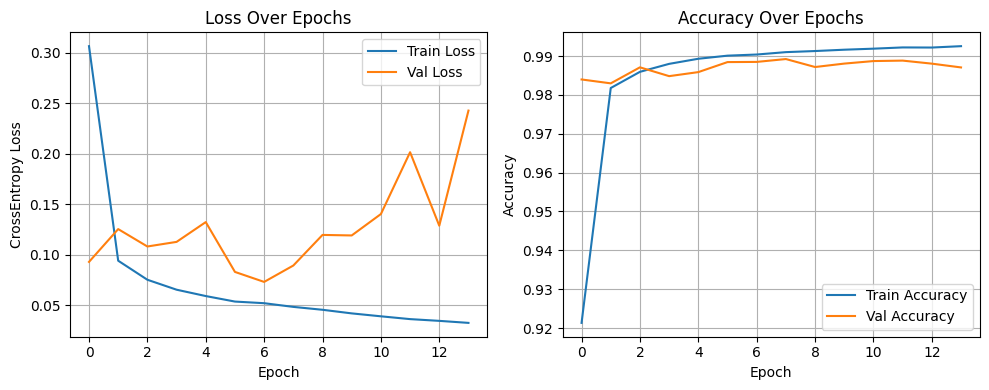

              precision    recall  f1-score   support

     Fault 0    0.99064   1.00000   0.99530    223440
     Fault 1    1.00000   0.99524   0.99762     11565
     Fault 2    0.99767   1.00000   0.99883     11565
     Fault 4    0.99211   1.00000   0.99604     11565
     Fault 5    0.93131   1.00000   0.96443     11565
     Fault 6    1.00000   1.00000   1.00000     11565
     Fault 7    0.99433   1.00000   0.99715     11565
     Fault 8    0.99260   0.97441   0.98342     11565
    Fault 10    0.99982   0.97562   0.98757     11565
    Fault 11    1.00000   0.99023   0.99509     11565
    Fault 12    0.99111   0.86779   0.92536     11565
    Fault 13    0.94271   0.97899   0.96051     11565
    Fault 14    0.99802   1.00000   0.99901     11565
    Fault 16    0.99481   0.97760   0.98613     11565
    Fault 17    1.00000   0.98340   0.99163     11565
    Fault 18    0.98447   0.93722   0.96027     11565
    Fault 19    1.00000   0.97847   0.98912     11565
    Fault 20    0.99751   0

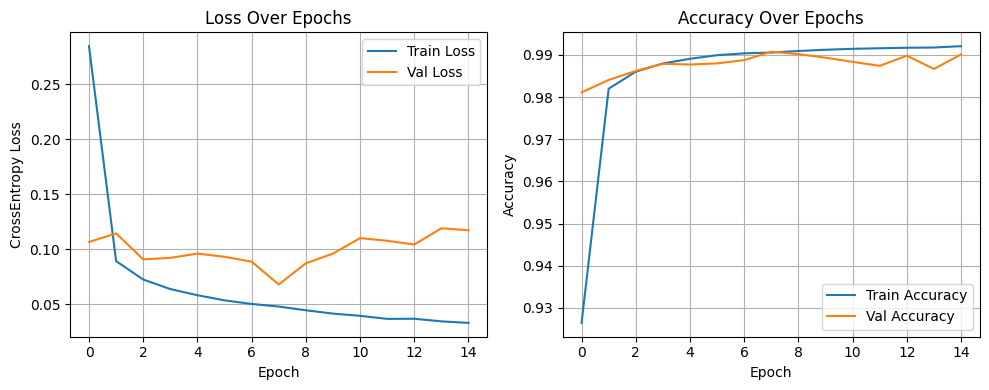

              precision    recall  f1-score   support

     Fault 0    0.99307   0.99998   0.99651    223440
     Fault 1    0.99561   0.99991   0.99776     11565
     Fault 2    1.00000   1.00000   1.00000     11565
     Fault 4    0.99681   1.00000   0.99840     11565
     Fault 5    0.94811   1.00000   0.97336     11565
     Fault 6    1.00000   1.00000   1.00000     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.96809   0.98366   0.97581     11565
    Fault 10    1.00000   0.98573   0.99282     11565
    Fault 11    1.00000   0.98997   0.99496     11565
    Fault 12    0.99492   0.88145   0.93476     11565
    Fault 13    0.95880   0.97985   0.96921     11565
    Fault 14    0.99510   1.00000   0.99754     11565
    Fault 16    0.99939   0.98772   0.99352     11565
    Fault 17    1.00000   0.98495   0.99242     11565
    Fault 18    0.98393   0.94743   0.96533     11565
    Fault 19    0.99956   0.99317   0.99636     11565
    Fault 20    0.99955   0

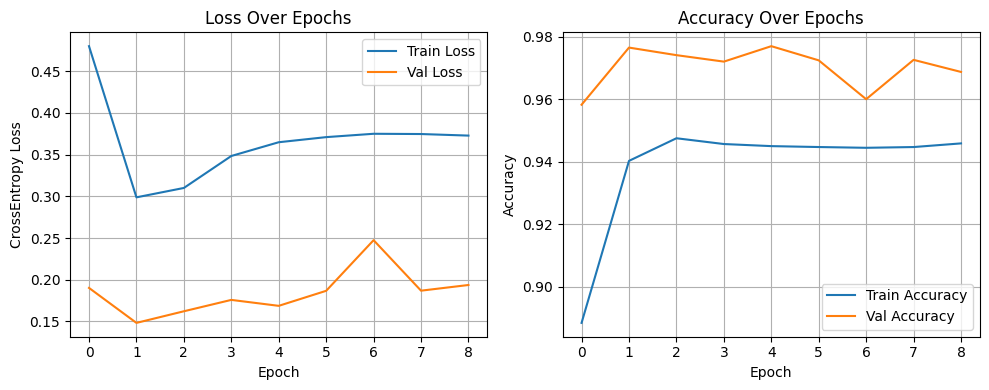

              precision    recall  f1-score   support

     Fault 0    0.98463   1.00000   0.99226    223440
     Fault 1    0.93203   0.99827   0.96401     11565
     Fault 2    0.99484   0.99948   0.99715     11565
     Fault 4    0.99168   1.00000   0.99582     11565
     Fault 5    0.94278   0.99732   0.96928     11565
     Fault 6    0.99888   1.00000   0.99944     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.99167   0.87462   0.92947     11565
    Fault 10    0.99030   0.92711   0.95766     11565
    Fault 11    0.99769   0.96974   0.98351     11565
    Fault 12    0.93901   0.85871   0.89707     11565
    Fault 13    0.97257   0.93498   0.95340     11565
    Fault 14    0.99922   1.00000   0.99961     11565
    Fault 16    0.96430   0.92953   0.94659     11565
    Fault 17    1.00000   0.97683   0.98828     11565
    Fault 18    0.95068   0.94008   0.94535     11565
    Fault 19    0.98855   0.97830   0.98340     11565
    Fault 20    0.96619   0

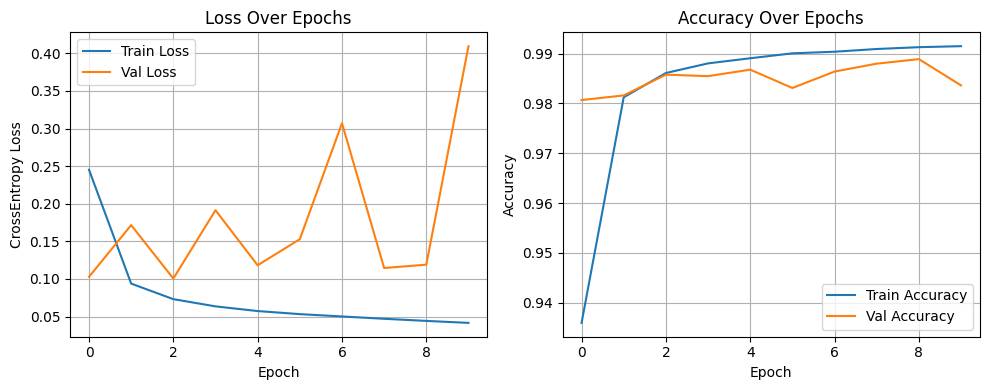

              precision    recall  f1-score   support

     Fault 0    0.98770   1.00000   0.99381    223440
     Fault 1    0.94316   1.00000   0.97075     11565
     Fault 2    0.99940   1.00000   0.99970     11565
     Fault 4    0.99836   1.00000   0.99918     11565
     Fault 5    0.98225   1.00000   0.99105     11565
     Fault 6    0.93372   1.00000   0.96572     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    1.00000   0.89070   0.94219     11565
    Fault 10    0.99777   0.96896   0.98315     11565
    Fault 11    1.00000   0.98911   0.99452     11565
    Fault 12    0.99316   0.86589   0.92517     11565
    Fault 13    0.98012   0.96334   0.97166     11565
    Fault 14    1.00000   1.00000   1.00000     11565
    Fault 16    0.99678   0.96498   0.98062     11565
    Fault 17    1.00000   0.98236   0.99110     11565
    Fault 18    0.94441   0.94457   0.94449     11565
    Fault 19    1.00000   0.98729   0.99360     11565
    Fault 20    0.99677   0

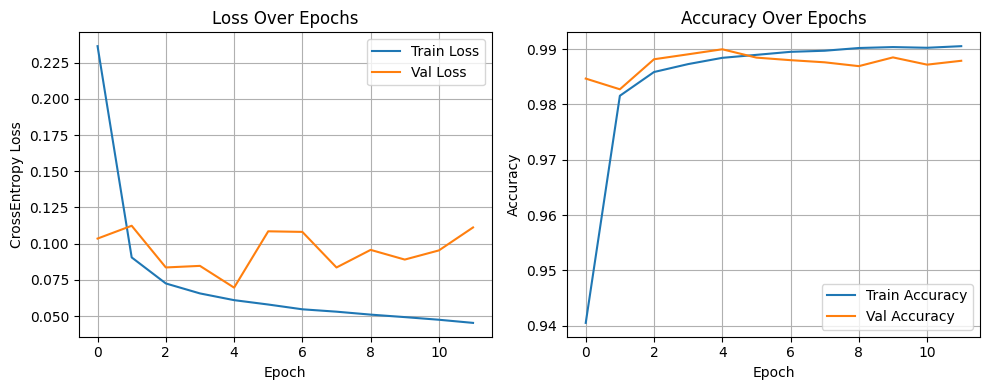

              precision    recall  f1-score   support

     Fault 0    0.99289   1.00000   0.99643    223440
     Fault 1    0.95444   1.00000   0.97669     11565
     Fault 2    0.99896   1.00000   0.99948     11565
     Fault 4    0.99715   1.00000   0.99858     11565
     Fault 5    0.99007   1.00000   0.99501     11565
     Fault 6    0.99974   1.00000   0.99987     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.99557   0.97121   0.98324     11565
    Fault 10    0.99816   0.98340   0.99072     11565
    Fault 11    0.99644   0.99101   0.99371     11565
    Fault 12    0.96722   0.88526   0.92442     11565
    Fault 13    0.97493   0.98176   0.97833     11565
    Fault 14    1.00000   1.00000   1.00000     11565
    Fault 16    0.99808   0.98772   0.99287     11565
    Fault 17    1.00000   0.98409   0.99198     11565
    Fault 18    0.95319   0.93679   0.94492     11565
    Fault 19    1.00000   0.99490   0.99744     11565
    Fault 20    1.00000   0

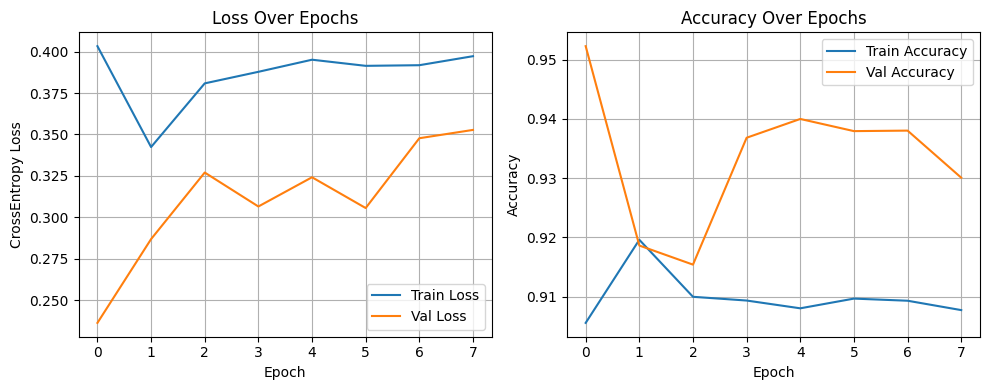

              precision    recall  f1-score   support

     Fault 0    0.97007   1.00000   0.98481    223440
     Fault 1    0.91557   0.99671   0.95442     11565
     Fault 2    0.96338   0.99395   0.97842     11565
     Fault 4    0.95832   1.00000   0.97872     11565
     Fault 5    0.99725   0.97328   0.98512     11565
     Fault 6    1.00000   0.94501   0.97173     11565
     Fault 7    0.99287   1.00000   0.99642     11565
     Fault 8    0.95110   0.84756   0.89635     11565
    Fault 10    0.78573   0.57423   0.66354     11565
    Fault 11    0.98011   0.94181   0.96058     11565
    Fault 12    0.99381   0.79092   0.88083     11565
    Fault 13    0.96099   0.91379   0.93680     11565
    Fault 14    1.00000   1.00000   1.00000     11565
    Fault 16    0.65384   0.70359   0.67780     11565
    Fault 17    0.98730   0.97458   0.98090     11565
    Fault 18    0.84124   0.95486   0.89446     11565
    Fault 19    0.99659   0.90886   0.95071     11565
    Fault 20    0.99802   0

In [20]:
lr_values = [5e-4, 1e-3]
wd_values = [0.0, 1e-4, 5e-3]

criterion = nn.CrossEntropyLoss(label_smoothing=0)

for l in lr_values:
    for w in wd_values:
        print(f"\nTraining with LR: {l} and WD: {w}\n")
        model = TransformerClassifier(
            input_dim=len(features),
            num_classes=num_classes,
        ).to(device)
        #print(model)

        optimizer = torch.optim.Adam(model.parameters(), lr=l, weight_decay=w)

        run_tag = f"lr_{l}_wd_{w}"
        info = train_classifier(
            model, train_loader, val_loader,
            criterion, optimizer,
            epochs=50, patience=7,
            grad_clip=1.0, scheduler_type="cosine",
            run_tag=run_tag, ckpt_dir="checkpoints",
            plot=True,          
            load_best=True     
        )
        all_probs = []
        all_preds = []
        all_targets = []

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                outputs = model(x_batch)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = np.argmax(probs, axis=1)

                all_probs.append(probs)
                all_preds.append(preds)
                all_targets.append(y_batch.numpy())

        # Concatenate all
        all_probs = np.vstack(all_probs)
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        index_to_label = {idx: label for label, idx in label_to_index.items()}

        label_names = [f"Fault {index_to_label[i]}" for i in range(num_classes)]

        # cm = confusion_matrix(all_targets, all_preds, normalize='true')
        # # print("Confusion Matrix:\n", cm)
        # plt.figure(figsize=(10, 7))
        # sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
        # plt.xlabel("Predicted")
        # plt.ylabel("True")
        # plt.title("Confusion Matrix")
        # plt.tight_layout()
        # plt.show()

        # Classification report
        print(classification_report(all_targets, all_preds, target_names=label_names, digits=5))